In [421]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Union, Tuple, Iterable, Optional, Any, Type
from tqdm import tqdm
from fancy_einsum import einsum

In [422]:
@dataclass
class Disease:
    beta: float
    gamma: float
    delta: float

In [423]:
def find_first_index(condition):
    """
    Finds the index of the first time a condition is met for each row in a 2D numpy array.

    Args:
        array: A 2D numpy array with n rows and m columns.
        condition: A boolean condition to be checked element-wise.

    Returns:
        A 1D numpy array containing the index of the first time the condition is met for each row in the input array.
        Returns -1 if the condition is never met in a row.
    """
    assert isinstance(condition, np.ndarray), "array must be a numpy array"
    assert len(condition.shape) == 2, "array must be a 2D numpy array"
    assert condition.shape[1] > 0, "array must have at least one column"

    # Apply the condition element-wise to the input array and get the index of the first True value along axis 1
    idx = np.argmax(condition, axis=1)
    
    # If the condition is never met in a row, set the corresponding index to -1
    idx[np.all(~condition, axis=1)] = -1
    
    return idx


In [424]:
class City:
    def __init__(self,
                 N0s: np.ndarray,
                 groups: list,
                 compartments: str = 'SEIR',
                 mixing_LR: Optional[np.ndarray] = None):
        """
        Initializes the City object.

        Args:
        - N0s (np.ndarray): An array of initial population sizes for each group.
        - groups (list): A list of strings representing the groups in the model.
        - compartments (str): A string representing the compartment model used in the model. Currently only 'SEIR' is supported.
        - mixing_LR (np.ndarray): An optional array representing the matrix of mixing likelihood ratios for groups i and j. All diagonal elements should be one.

        Returns:
        - None
        """
        self.n_groups = len(groups)
        self.groups = groups

        # Check that the length of N0s matches the number of groups
        assert len(N0s) == self.n_groups, "N0s should have length n_groups"

        self.N0s = N0s
        self.N0 = self.N0s.sum()

        assert compartments == 'SEIR', "Only SEIR compartment model supported at the moment"
        self.model_type = compartments
        self.compartments = [l for l in compartments]

        # Check and set the mixing_LR matrix
        if mixing_LR is None:
            mixing_LR = np.identity(self.n_groups)
        assert mixing_LR.shape == (self.n_groups, self.n_groups)
        assert np.all(mixing_LR.diagonal() == 1)
        assert np.all(mixing_LR == mixing_LR.T)
        self.mixing_LR = mixing_LR

        # Set the indices of the compartments
        self.S_index = self.compartments.index('S')
        self.E_index = self.compartments.index('E')
        self.I_index = self.compartments.index('I')
        self.R_index = self.compartments.index('R')

    def reset_parameters(self, I0: int = 0, n_sims: int = 1, simulation_steps: int = 100):
        """
        Sets self.data to an array of zeros of size (n_groups, n_compartments, n_sims, timesteps) for each compartment in the city
        The only values which aren't zero are the initial value of I which is I0 and the initial value of S which is N-I0
        The default value of I0 is the value set in the class initialization, but can be overridden
        """
        # if I0 is None:
        #     I0 = self.I0
        self.I0 = I0
        self.data = np.zeros((self.n_groups,len(self.compartments),self.n_sims, self.simulation_steps),dtype = np.int64)
        self.arrivals = np.zeros((self.n_groups,len(self.compartments),self.n_sims, self.simulation_steps),dtype = np.int64)
        self.departures = np.zeros((self.n_groups,len(self.compartments),self.n_sims, self.simulation_steps),dtype = np.int64)
        self.initial_conditions()
    
    def initial_conditions(self):
        raise ModuleNotFoundError
    
    def multiple_sims(self, delta_t: float, epidemic_time: Union[int,float], disease: Disease, I0: int = 0, n_sims: int = 100):
        assert (1 / delta_t) % 1 == 0, "1/delta_t must be an integer"
        self.n_sims = n_sims
        self.delta_t = delta_t
        self.epidemic_time = epidemic_time
        p_recovery = 1 - np.exp( - delta_t * disease.gamma)
        p_infectious = 1 - np.exp( - delta_t * disease.delta)
        self.simulation_steps = int(epidemic_time // delta_t) + 1
        self.times = np.linspace(0, epidemic_time, self.simulation_steps)
        self.reset_parameters(I0, n_sims, self.simulation_steps)
        for sim_step in tqdm(range(1,self.simulation_steps)):
            self.step_internal(disease.beta,
                      delta_t,
                      p_infectious,
                      p_recovery,
                      sim_step)
        self.daily_flight_data()
    
    def __call__(self,
                 delta_t: float,
                 epidemic_time: Union[int,float],
                 disease: Disease,
                 I0: int = 0,
                 n_sims: int = 100):
        return self.multiple_sims(delta_t, epidemic_time, disease, I0, n_sims)

    def step_internal(self,
                      beta:float,
                      delta_t: float,
                      p_infectious: float,
                      p_recovery: float,
                      simulation_step: int):
        N = self.data[...,simulation_step-1].sum(axis = 1)
        
        S = self.data[:,self.S_index,:,simulation_step-1]
        E = self.data[:,self.E_index,:,simulation_step-1]
        I = self.data[:,self.I_index,:,simulation_step-1]
        R = self.data[:,self.R_index,:,simulation_step-1]


        modified_I = einsum('group1 group2, group2 n_sims -> group1 n_sims', self.mixing_LR, I)
        modified_N = einsum('group1 group2, group2 n_sims -> group1 n_sims', self.mixing_LR, N)
        exposure_rate = beta * modified_I/modified_N
        p_exposure = 1 - np.exp(- delta_t * exposure_rate)
        n_exposed = np.random.binomial(S, p_exposure)
        n_infectious = np.random.binomial(E,p_infectious)
        n_recovered = np.random.binomial(I,p_recovery)

        self.data[:,self.S_index,:,simulation_step] = S - n_exposed
        self.data[:,self.E_index,:,simulation_step] = E + n_exposed - n_infectious
        self.data[:,self.I_index,:,simulation_step] = I + n_infectious - n_recovered
        self.data[:,self.R_index,:,simulation_step] = R + n_recovered

    def daily_flight_data(self, moving_average = False):
        window = int(1/self.delta_t)
        self.daily_arrivals = self.arrivals.reshape((self.n_groups, len(self.compartments), self.n_sims, self.simulation_steps//window, window)).sum(axis = -1)
        self.daily_departures = self.departures.reshape((self.n_groups, len(self.compartments), self.n_sims, self.simulation_steps//window, window)).sum(axis = -1)

    def select_travellers(self, daily_mixnumber: int, simulation_step: int):
        raise ModuleNotFoundError

    def plot_sims(self,
                  times: Optional[np.ndarray] = None,
                  cityname: Union[int,str] = 0, 
                  shift_index: Optional[np.ndarray] = None,
                  separate_groups: bool = False):
        include_flight_data = 'arrivals' in dir(self)
        subplots = self.n_groups if separate_groups else 1
        if include_flight_data:
            fig, axs = plt.subplots(3,subplots, figsize = (20,30))
            axs = np.array(axs)
        else:
            fig, axs = plt.subplots(1,subplots, figsize = (20,10))
            axs = np.expand_dims(np.array(axs),0)
        if self.n_groups == 1:
            axs = np.expand_dims(axs, -1)
        if times is None:
            times = self.times
        if shift_index is None:
            shift = np.zeros((self.n_sims,1))
        else:
            shift = times[shift_index].reshape((self.n_sims,1))
        # assert shift.shape == (self.n_sims,1), "Wrong shift shape"
        days = np.array(range(int(max(times))), dtype = np.float64)
        
        times = times - shift + shift.mean()
        days = days - shift + shift.mean()
        cols = ['green', 'orange', 'red', 'blue']
        labels = ['Whole City', 'Arrivals', 'Departures']
        if separate_groups:
            for i, group in enumerate(self.groups):
                for j,compartment in tqdm(enumerate(self.compartments)):
                    axs[0,i].plot(times[0],
                                self.data[i,j,0],
                                label = compartment,
                                color = cols[j])
                    if include_flight_data:
                        axs[1,i].plot(days[0],  
                                    self.daily_arrivals[i,j,0],
                                    label = compartment,
                                    color = cols[j])
                        axs[2,i].plot(days[0],
                                    self.daily_departures[i,j,0],
                                    label = compartment,
                                    color = cols[j])
                    for k,datum in enumerate(self.data[i,j,1:]):
                        axs[0,i].plot(times[k+1], datum, color = cols[j])
                    if include_flight_data:
                        for k, (arrival, departure) in enumerate(zip(self.daily_arrivals[i,j,1:],self.daily_departures[i,j,1:])):
                            axs[1,i].plot(days[k+1], arrival, color = cols[j])
                            axs[2,i].plot(days[k+1], departure, color = cols[j])
                num_subplots = axs.shape[0]
                for j in range(num_subplots):
                    axs[j,i].legend()
                    axs[j,i].set_title(f"City {cityname}, {group}: {labels[j]}")
        else:
            for j, compartment in tqdm(enumerate(self.compartments)):
                axs[0].plot(times[0],
                            self.data[:,j,0].sum(axis = 0),
                            label = compartment,
                            color = cols[j])
                if include_flight_data:
                    axs[1].plot(days[0],
                                self.daily_arrivals[:,j,0].sum(axis = 0),
                                label = compartment,
                                color = cols[j])
                    axs[2].plot(days[0],
                                self.daily_departures[:,j,0].sum(axis = 0),
                                label = compartment,
                                color = cols[j])
                for k,datum in enumerate(self.data[:,j,1:].sum(axis = 0)):
                    axs[0].plot(times[k+1], datum, color = cols[j])
                    if include_flight_data:
                        for k, (arrival, departure) in enumerate(zip(self.daily_arrivals[:,j,1:].sum(axis = 0),self.daily_departures[:,j,1:].sum(axis = 0))):
                            axs[1].plot(days[k+1], arrival, color = cols[j])
                            axs[2].plot(days[k+1], departure, color = cols[j])
            num_subplots = axs.shape[0]
            for j in range(num_subplots):
                axs[j].legend()
                axs[j].set_title(f"City {cityname}: {labels[j]}")
        fig.show()
    
    def infections_at_time(self, community: str = 'data', sim_steps: Optional[np.ndarray] = None, time: Optional[np.ndarray] = None, included_compartments: str = 'EIR'):
        """
        Returns the number of people who are in included compartments at the given sim_steps
        sim_steps: size (n_sims) the (different) simulation_step at which to evaluate number who have been exposed for each simulation
        """
        assert community in ['data','arrivals','departures']
        assert (time is not None) != (sim_steps is not None), "Exactly one of time_indexes and times should be specified"
        if sim_steps is None:
            assert time is not None
            sim_steps = self.times.searchsorted(time)
        assert len(sim_steps) == self.n_sims, "len(times) must be n_sims"
        # values = np.zeros((self.n_sims,2,4))
        to_include = np.array([l in included_compartments for l in self.compartments])
        if community == 'data':
            out = self.data[:,to_include,].sum(axis = (0,1))
        elif community == 'arrivals':
            out = self.arrivals[:,to_include,].sum(axis = (0,1))
        else:
            out = self.departures[:,to_include,].sum(axis = (0,1))
        out = out[np.array(range(self.n_sims)),sim_steps]
        # for i,group in enumerate(self.groups):
        #     out[group] = np.zeros(self.n_sims)
        #     for j, compartment in enumerate(self.compartments):
        #         # values[:,i,j] = self.data[group][compartment][np.array(range(self.n_sims)),time_indexes]
        #         if compartment in to_include:
        #             out[group] += self.data[group][compartment][np.array(range(self.n_sims)),time_indexes]
        #     # out[group] = values[:,i].sum(axis = -1) - values[:,i,0]
        #     assert out[group].shape == (self.n_sims,), "Logical Error Somewhere!"
        # out['total'] = sum([out[group] for group in self.groups])
        return out

    def simstep_at_infections(self, community: str = 'data', infection_threshold: Union[int,float] = 0.01, included_groups: Optional[Union[list[int],list[str]]] = None, included_compartments: str = 'EIR'):
        """
        infection_threshold: if >= 1, the number of infections to cross the threshold. if < 1, the fraction of the population to cross the threshold
        included_groups: the groups we care about for the threshold. Default: everyone. This argument is useful if we are only monitoring the normal people for example
        included_compartments: the compartments that count as infections. We may only care about E or I, but default is EIR
        out: shape (n_sims): the simulation step for each sim when the number of infections crosses the specifed threshold 
        """
        assert community in ['data','arrivals','departures']
        if included_groups is None:
            groups_to_include = np.ones(self.n_groups).astype(bool)
        else:
            if isinstance(included_groups[0],int):
                groups_to_include = np.array([group in included_groups for group in range(self.n_groups)])
            else:
                groups_to_include = np.array([group in included_groups for group in self.groups])
        compartments_to_include = np.array([compartment in included_compartments for compartment in self.compartments])

        if community == 'data':
            relevant_people = self.data[groups_to_include].sum(axis = 0)
        elif community == 'arrivals':
            relevant_people = self.arrivals[groups_to_include].sum(axis = 0)
        else:
            relevant_people = self.departures[groups_to_include].sum(axis = 0)
        infected = relevant_people[compartments_to_include].sum(axis = 0)
        fraction_infected = infected / relevant_people
        if infection_threshold > 1:
            return find_first_index(infected > infection_threshold)
        else:
            return find_first_index(infected / relevant_people.sum(axis = 0) > infection_threshold)

    def peak_I_times(self):
        return self.data[:,self.I_index].sum(axis = 0).argmax(axis = -1)

    def __str__(self):
        raise ModuleNotFoundError

    def hist_arrivals_at_municipal_threshold(self,
                                             thresholds: Optional[list[float]] = None,
                                             municipal_compartments: str = 'EI',
                                             arrival_compartments: str = 'EI',
                                             fig = None, ax = None, figsavename: Optional[str] = None):
        """
        For each threshold in threshold, plot the distribution of fractions of infected and exposed people in the arrivals on the day that the fraction of infected and exposed people in the main city crosses the threshold
        """
        if thresholds is None:
            thresholds = [1e-3,1e-2,1e-1]
        n_plots = len(thresholds)
        if ax is None:
            fig, axs = plt.subplots(n_plots,1,figsize=(15,30))
        assert fig is not None
        for i,threshold in enumerate(thresholds):
            sim_steps = self.simstep_at_infections('data', threshold, included_compartments=municipal_compartments)
            arrival_infections = self.infections_at_time('arrivals', sim_steps,included_compartments=arrival_compartments)
            arrival_total = self.infections_at_time('arrivals', sim_steps,included_compartments='SEIR')
            # assert (arrival_infections.shape == (self.n_sims) and (arrival_total.shape == self.n_sims) 
            infection_fraction = arrival_infections / arrival_total
            axs[i].hist(infection_fraction, bins = 15, density = True, label = "Arrivals")#,range = (0, threshold * 10))
            axs[i].set_xlabel('Fraction of People that are Exposed or Infected', fontsize = 15)
            axs[i].axvline(threshold,linewidth = 4, color = 'r', label = "Main City")
            axs[i].legend(fontsize = 15)
        if figsavename is None:
            fig.show()
        else:
            fig.savefig(figsavename)

    def hist_municipal_at_arrivals_threshold(self,
                                             thresholds: Optional[list[float]] = None,
                                             municipal_compartments: str = 'EI',
                                             arrival_compartments: str = 'EI',
                                             fig = None, ax = None, figsavename: Optional[str] = None):
        """
        For each threshold in threshold, plot the distribution of fractions of infected and exposed people in the main city on the day that the fraction of infected and exposed people in the arrivals crosses the threshold
        TO DO: average over a few days, since arrival data is noisy and crosses low thresholds randomly very early. 
        """
        if thresholds is None:
            thresholds = [1e-3,1e-2,1e-1]
        n_plots = len(thresholds)
        if ax is None:
            fig, axs = plt.subplots(n_plots,1,figsize=(15,30))
        assert fig is not None
        for i,threshold in enumerate(thresholds):
            sim_steps = self.simstep_at_infections('arrivals', threshold, included_compartments=municipal_compartments)
            municipal_infections = self.infections_at_time('data', sim_steps,included_compartments=arrival_compartments)
            municipal_total = self.infections_at_time('data', sim_steps,included_compartments='SEIR')
            # assert (arrival_infections.shape == (self.n_sims) and (arrival_total.shape == self.n_sims) 
            infection_fraction = municipal_infections / municipal_total
            axs[i].hist(infection_fraction, bins = 15, density = True, label = "Main City")#,range = (0, threshold * 10))
            axs[i].set_xlabel('Fraction of People that are Exposed or Infected', fontsize = 15)
            axs[i].axvline(threshold,linewidth = 4, color = 'r', label = "Arrivals")
            axs[i].legend(fontsize = 15)
        
        if figsavename is None:
            fig.show()
        else:
            fig.savefig(figsavename)
          
    def plot_avg_vals(self, to_include: list[str] = ['data', 'arrivals'], included_compartments = 'EIR',
                      error_bars: bool = True, fig = None, ax = None, figsavename: Optional[str] = None):
        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(15,10))
        assert fig is not None
        assert all([community in ['data','arrivals','departures'] for community in to_include])
        line_colours = ['blue', 'red', 'green']
        error_bar_cols = ['cornflowerblue','lightcoral','mediumaquamarine']
        for i,community in enumerate(set(to_include)):
            if community == 'data':
                values = self.data
            elif community == 'arrivals':
                values = self.arrivals
            else:
                values = self.departures
            compartments_to_include = np.array([l in included_compartments for l in self.compartments])
            values = values[:,compartments_to_include].sum(axis = (0,1)) / values.sum(axis = (0,1))
            means = values.mean(axis = 0)
            stds = values.std(axis = 0)
            label = 'Main City' if community == 'data' else community
            if error_bars:
                ax.errorbar(self.times,means,yerr=stds, label = label, color = line_colours[i], ecolor = error_bar_cols[i])
            else:
                ax.plot(self.times,means, label = label)
        ax.set_xlabel('Time (days)', fontsize = 15)
        ax.set_ylabel(f'Fraction of population in disease state {included_compartments}')
        ax.legend(fontsize = 15)
        if figsavename is None:
            fig.show()
        else:
            fig.savefig(figsavename)


In [425]:
class FrequentFlierCity(City):
    def __init__(self,
                 N0: int = 10**6,
                 frequent_flier_frac: float = 0.1,
                 p_ff: Optional[float] = None,
                 flying_LR: Optional[float] = None,
                 mixing_LR: float = 5,
                 compartments: str = 'SEIR'):
        mixing_LR_matrix = np.array([[1.,1/mixing_LR],[1/mixing_LR,1.]])
        self.groups = ['normal', 'frequent_fliers']
        self.N0s = np.array([N0 * (1 - frequent_flier_frac), N0 * frequent_flier_frac],dtype = np.int64)
        super().__init__(self.N0s, self.groups, compartments, mixing_LR_matrix)
        self.frequent_flier_frac = frequent_flier_frac
        if (p_ff is None) and (flying_LR is None):
            flying_LR = 10
        assert (p_ff is None) != (flying_LR is None), "Specify exactly one of p_ff OR flying_LR!"
        if flying_LR is not None:
            self.flying_LR = flying_LR
            self.p_ff = flying_LR * frequent_flier_frac/ (flying_LR * frequent_flier_frac + (1 - frequent_flier_frac))
        if p_ff is not None:
            self.p_ff = p_ff
            self.flying_LR = (p_ff / frequent_flier_frac) / ((1-p_ff) / (1 - frequent_flier_frac))

    def initial_conditions(self):
        I_n = np.random.binomial(self.I0, 1-self.frequent_flier_frac, self.n_sims)
        I_ff = self.I0 - I_n
        self.data[0,2,:,0] = I_n
        self.data[1,2,:,0] = I_ff
        self.data[0,0,:,0] = self.N0s[0] - I_n
        self.data[1,0,:,0] = self.N0s[1] - I_ff

    def __str__(self):
        out = 'City Type:\n FrequentFlierCity'
        out += f'\nN:\n {self.N0}'
        out += f'\nfrequent_flier_frac:\n {self.frequent_flier_frac}'
        out += f'\nflying_LR:\n {self.flying_LR}'
        out += f'\np_ff:\n {self.p_ff}'
        out += f'\nmixing_LR:\n {self.mixing_LR}'
        return out

    # def select_travellers(self, daily_mixnumber: int, simulation_step: int):
        

In [426]:
measles = Disease(1.5, 1/8,1/10)

In [427]:
class BasicCity(City):
    def __init__(self,
                 N0: int = 10**6,
                 compartments: str = 'SEIR'):
        mixing_LR_matrix = np.array([[1.]])
        self.groups = ['normal']
        self.N0s = np.array([N0],dtype = np.int64)
        super().__init__(self.N0s, self.groups, compartments, mixing_LR_matrix)
    
    def initial_conditions(self):
        self.data[0,2,:,0] = self.I0
        self.data[0,0,:,0] = self.N0s[0] - self.I0
    
    def __str__(self):
        out = 'City Type:\n BasicCity'
        out += f'\nN:\n {self.N0}'
        return out

    def select_travellers(self, daily_mixnumber: int, simulation_step: int):
        p_travel = 1 - np.exp(- self.delta_t * daily_mixnumber / self.N0)
        return np.random.binomial(self.data[...,simulation_step],p_travel)

In [428]:
class Travel:
    def __init__(self,
                 cities: list[City],
                 mixmatrix: np.ndarray,
                 city_names: Optional[list[str]] = None):
        self.cities = cities
        self.n_cities = len(cities)
        self.city_names = list(range(self.n_cities)) if city_names is None else city_names
        self.mixmatrix = mixmatrix.astype(np.int64)
        assert np.all(mixmatrix == mixmatrix.T), "mixmatrix must be symmetrical!"
        assert np.trace(mixmatrix) == 0, "mixmatrix must be traceless!"
        self.n_groups = 0
        self.categories = []
        self.I0s = []
    
    def reset_parameters(self):
        for i,city in enumerate(self.cities):
            city.reset_parameters(I0 = self.I0s[i],
                                  n_sims = self.n_sims,
                                  simulation_steps = self.simulation_steps)
    
    def step(self,
            beta:float,
            delta_t: float,
            p_infectious: float,
            p_recovery: float,
            simulation_step: int,
            n_sims: int):
        changes = np.zeros((self.n_cities,self.n_groups,len(self.categories),n_sims), dtype = np.int64)
        arrivals = np.zeros((self.n_cities,self.n_groups,len(self.categories),n_sims), dtype = np.int64)
        departures = np.zeros((self.n_cities,self.n_groups,len(self.categories),n_sims), dtype = np.int64)
        for i,city in enumerate(self.cities):
            #First, do the interal spread within each city
            city.step_internal(beta,
                               delta_t,
                               p_infectious,
                               p_recovery,
                               simulation_step)
        for i, city_i in enumerate(self.cities[:-1]):
            for j, city_j in enumerate(self.cities[i+1:]):
                j += i+1
                mix = self.mixmatrix[i,j]
                if mix == 0:
                    continue
                travel_ij = city_i.select_travellers(mix, simulation_step)
                travel_ji = city_j.select_travellers(mix, simulation_step)
                
                city_i.data[...,simulation_step] += travel_ji - travel_ij
                city_i.arrivals[...,simulation_step] += travel_ji
                city_i.departures[...,simulation_step] += travel_ij
                
                city_j.data[...,simulation_step] += travel_ij - travel_ji
                city_j.arrivals[...,simulation_step] += travel_ij
                city_j.departures[...,simulation_step] += travel_ji
    
    def multiple_sims(self,
                      delta_t: float,
                      epidemic_time: Union[int,float],
                      disease: Disease,
                      I0s: Union[int,float,list[int],list[float], np.ndarray],
                      n_sims: int = 100):
        if isinstance(I0s, np.ndarray):
            assert I0s.dtype == np.int64
        elif isinstance(I0s, int):
            I0s = np.array([I0s] + [0] * (len(self.cities) - 1))
        elif isinstance(I0s, float):
            I0s = np.array([I0s * self.cities[0].N0] + [0] * (len(self.cities) - 1))
        elif isinstance(I0s, list):
            I0s = [I * self.cities[j].N0 if isinstance(I,float) else I for j,I in enumerate(I0s)]
            I0s = np.array(I0s)
        self.I0s = I0s
        assert (1 / delta_t) % 1 == 0, "1/delta_t must be an integer"
        self.start_city = self.cities[[I0 != 0 for I0 in I0s].index(True)]
        p_recovery = 1 - np.exp( - delta_t * disease.gamma)
        p_infectious = 1 - np.exp( - delta_t * disease.delta)
        self.simulation_steps = int(epidemic_time // delta_t) + 1
        self.n_sims = n_sims
        self.times = np.linspace(0, epidemic_time, self.simulation_steps)
        for city in self.cities:
            city.delta_t = delta_t
            city.n_sims = n_sims
            city.epidemic_time = epidemic_time
            city.times = self.times
            city.simulation_steps = self.simulation_steps
        self.reset_parameters()
        for simulation_step in tqdm(range(1,self.simulation_steps)):
            self.step(disease.beta,
                      delta_t,
                      p_infectious,
                      p_recovery,
                      simulation_step,
                      n_sims)
        for city in self.cities:
            city.daily_flight_data()
        
    def __str__(self):
        out = ''
        for i, city in enumerate(self.cities):
            out += f'City: {self.city_names[i]}\n'
            out += str(city) + '\n'
        if self.I0s is not None:
            out += f'I0s: {self.I0s}\n'
        out += f'Mixmatrix: {self.mixmatrix}'
        return out
    
    def plot_sims(self,
                  to_shift: bool = True,
                  included: Optional[Union[list[int],list[str]]] = None,
                  separate_groups: bool = True):
        included_names = []
        if included is None:
            included = list(range(len(self.cities)))
            included_names = included
        elif isinstance(included[0],int):
            included_names = included
        elif isinstance(included[0],str):
            included_names = included
            included = [i for i, name in enumerate(self.city_names) if name in included]
        shift_index = None
        if to_shift:
            shift_index = self.start_city.data[:,self.start_city.I_index].sum(axis=0).argmax(axis = 1)
        for i, city in enumerate(self.cities):
            if i in included:
                print(f"CITY {included_names[i]}:")
                city.plot_sims(times = self.times, cityname=i, shift_index = shift_index, separate_groups=separate_groups)
                print('\n')

    def __call__(self,
                 delta_t: float,
                 epidemic_time: Union[int,float],
                 disease: Disease,
                 I0s: Union[int,float,list[int],list[float], np.ndarray],
                 n_sims: int = 100):
        return self.multiple_sims(delta_t, epidemic_time, disease, I0s, n_sims)
             
    def plot_avg_vals(self, which_city: int = -1,
                      to_include: list[str] = ['data', 'arrivals'], included_compartments = 'EIR', against_total_infections: bool = False,
                      error_bars: bool = True, fig = None, ax = None, figsavename: Optional[str] = None):
        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(15,10))
        assert fig is not None
        assert all([community in ['data','arrivals','departures'] for community in to_include])

        line_colours = ['blue', 'red', 'green']
        error_bar_cols = ['cornflowerblue','lightcoral','mediumaquamarine']
        compartments_to_include = np.array([l in included_compartments for l in self.cities[0].compartments])

        if against_total_infections:
            total_infections = self.cities[0].data[:,compartments_to_include].sum(axis = (0,1))
            for city in self.cities[1:]:
                total_infections += city.data[:,compartments_to_include].sum(axis = (0,1))
            x_axis = total_infections.mean(axis = 0)
            x_std = total_infections.std(axis = 0)
        else:
            x_axis = self.times
            x_std = np.zeros_like(self.times)
        
        city = self.cities[which_city]

        for i,community in enumerate(set(to_include)):
            if community == 'data':
                values = city.data
            elif community == 'arrivals':
                values = city.arrivals
            else:
                values = city.departures
            values = values[:,compartments_to_include].sum(axis = (0,1)) / values.sum(axis = (0,1))
            means = values.mean(axis = 0)
            stds = values.std(axis = 0)
            label = 'Main City' if community == 'data' else community
            if error_bars:
                ax.errorbar(x_axis,means,yerr=stds, xerr = x_std, label = label, color = line_colours[i], ecolor = error_bar_cols[i])
            else:
                ax.plot(x_axis,means, label = label)
        if against_total_infections:
            ax.set_xlabel('Total Infections', fontsize = 15)
        else:
            ax.set_xlabel('Time (days)', fontsize = 15)
        ax.set_ylabel(f'Fraction of population in disease state {included_compartments}')
        ax.legend(fontsize = 15)
        if figsavename is None:
            fig.show()
        else:
            fig.savefig(figsavename)
    

In [429]:
class HomogeneousNetwork(Travel):
    def __init__(self,
                 citytype: Type,
                 n_cities: int,
                 mixnumber: int,
                 *args, **kwargs):
        cities = []
        for i in range(n_cities):
            cities.append(citytype(*args, **kwargs))
        mixmatrix = (np.ones((n_cities,n_cities)) - np.identity(n_cities)).astype(np.int64) * mixnumber
        super().__init__(cities, mixmatrix)


In [438]:
basics = HomogeneousNetwork(BasicCity,3,10000)

In [439]:
basics(0.05,100,measles,20,200)

100%|██████████| 1999/1999 [00:03<00:00, 621.28it/s]


/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_61639/1298868419.py:167: RuntimeWarning: invalid value encountered in divide
  values = values[:,compartments_to_include].sum(axis = (0,1)) / values.sum(axis = (0,1))
/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_61639/1298868419.py:182: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


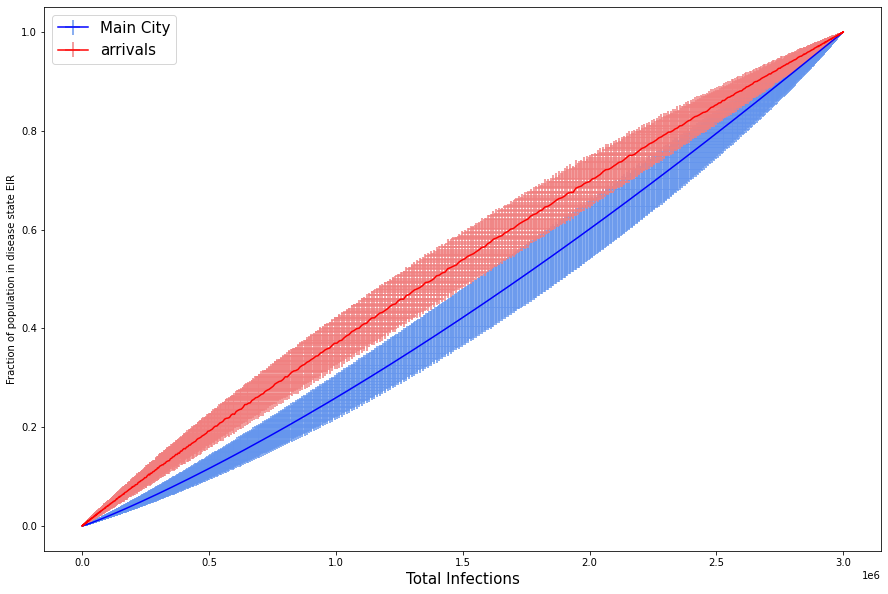

In [443]:
basics.plot_avg_vals(which_city = -1, against_total_infections=True, included_compartments='EIR')

/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_61639/3891715418.py:348: RuntimeWarning: invalid value encountered in divide
  values = values[:,compartments_to_include].sum(axis = (0,1)) / values.sum(axis = (0,1))
/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_61639/3891715418.py:360: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


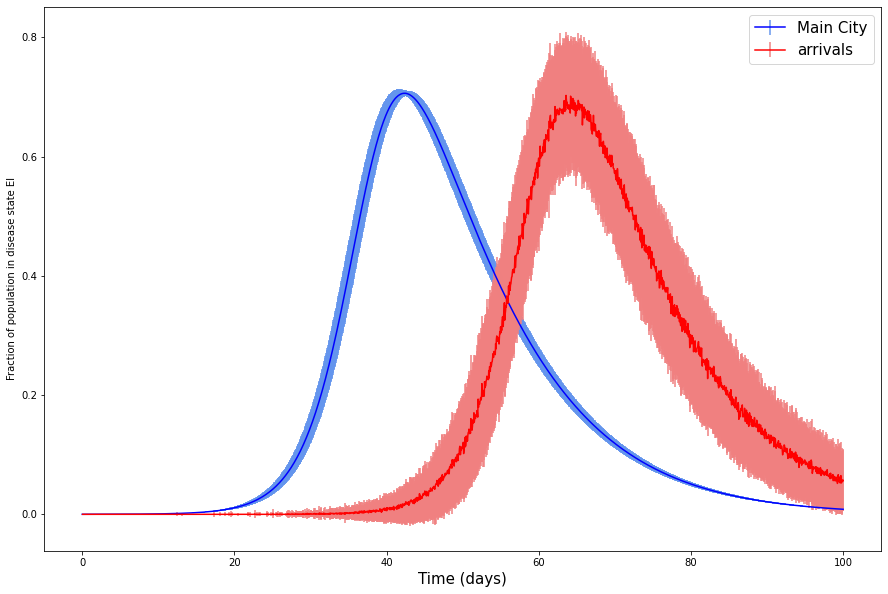

In [377]:
basics.cities[0].plot_avg_vals(included_compartments='EI')